In [19]:
import numpy as np
import pandas as pd
import pyagrum as gum
import pyagrum.lib.notebook as gnb
import pyagrum.causal as csl
import pyagrum.causal.notebook as cslnb
import itertools
import networkx as nx
import matplotlib.pyplot as plt

In [20]:
# Create the combined Bayesian network for the depression model
bn = gum.BayesNet("CombinedDepressionModel")

# -----------------------------------------
# Socio-Demographic Branch
# -----------------------------------------
# Define independent nodes for education, income, and job status.
edu = bn.add(gum.LabelizedVariable("Education", "Education Level", ["Low", "Medium", "High"]))
inc = bn.add(gum.LabelizedVariable("Income", "Income Level", ["Low", "Medium", "High"]))
# job = bn.add(gum.LabelizedVariable("Job", "Job Level", ["Unemployed", "Employed"]))

# Set the prior probability for the Income node (source: Pew Research on income inequality trends)
bn.cpt(inc).fillWith([0.09, 0.43, 0.48])

# Define an aggregated node for overall socioeconomic status.
socio = bn.add(gum.LabelizedVariable("SocioStatus", "Overall Socioeconomic Status", ["High", "Low"]))

# Create arcs from the individual socio-demographic nodes to the aggregated SocioStatus node.
bn.addArc(inc, socio)
bn.addArc(edu, socio)
# bn.addArc(job, socio)

# -----------------------------------------
# Physical Health Branch
# -----------------------------------------
# Define independent nodes for physical activity level and obesity status.
physicalActivity = bn.add(gum.LabelizedVariable("Physical Activity", "Physical Activity Level", ["Inactive", "Active"]))
obesity = bn.add(gum.LabelizedVariable("Obesity", "Obesity Status", ["Obese", "Not Obese"]))

# Define an aggregated node representing overall physical health attribute.
physattri = bn.add(gum.LabelizedVariable("Physical Attribute", "Overall Physical Attribute", ["Good", "Poor"]))

# Create arcs from the physical health nodes to the aggregated Physical Attribute node.
bn.addArc(physicalActivity, physattri)
bn.addArc(obesity, physattri)

# -----------------------------------------
# Additional Independent Factors
# -----------------------------------------
# Add node for Genetic Predisposition with states: Absent and Present.
genetic = bn.add(gum.LabelizedVariable("GeneticPredisposition", "Genetic Predisposition", ["Absent", "Present"]))
bn.cpt(genetic).fillWith([0.6, 0.4])

# Add node for Adverse Childhood Experiences with states: Absent and Present.
adverse = bn.add(gum.LabelizedVariable("AdverseChildhood", "Adverse Childhood Experiences", ["Absent", "Present"]))
bn.cpt(adverse).fillWith([0.361, 0.639])

# Add node for Chatbot intervention with states: No and Yes.
AI = bn.add(gum.LabelizedVariable("Artificial Intelligence", "Artificial Intelligence", ["No", "Yes"]))
bn.cpt(AI).fillWith([1, 0])

# Add node for therapy with states: No and Yes.
trad = bn.add(gum.LabelizedVariable("Traditional Methods", "Traditional Methods", ["No", "Yes"]))
bn.cpt(trad).fillWith([1, 0])

# -----------------------------------------
# Outcome Node: Depression
# -----------------------------------------
# Define the outcome node for Depression (No/Yes)
depress = bn.add(gum.LabelizedVariable("Depression", "Depression Status", ["No", "Yes"]))

# Create arcs from all contributing factors to the Depression node.
bn.addArc(socio, depress)
bn.addArc(physattri, depress)
bn.addArc(genetic, depress)
bn.addArc(adverse, depress)
bn.addArc(AI, depress)
bn.addArc(trad, depress)

In [21]:
df_job = pd.read_csv('job.csv', delimiter=';', decimal=',')
df_job.rename(columns={
    'Beroeps- en niet-beroepsbev. met inkomen/Beroeps- en niet-beroepsbev. met inkomen (x 1 000)': 'job'
}, inplace=True)
# Drop the columns 'Geslacht' and 'Perioden' from df_job
df_job.drop(columns=['Geslacht', 'Perioden'], inplace=True)
df_job

,Arbeidspositie,Persoonskenmerken,job
0,Werkzame beroepsbevolking,Onderwijsniveau: 1 laag,1540
1,Werkzame beroepsbevolking,Onderwijsniveau: 2 middelbaar,3299
2,Werkzame beroepsbevolking,Onderwijsniveau: 3 hoog,3409
3,Werkzame beroepsbevolking,Leeftijd: 15 tot 25 jaar,1212
4,Werkzame beroepsbevolking,Leeftijd: 25 tot 35 jaar,1779
5,Werkzame beroepsbevolking,Leeftijd: 35 tot 45 jaar,1607
6,Werkzame beroepsbevolking,Leeftijd: 45 tot 55 jaar,1904
7,Werkzame beroepsbevolking,Leeftijd: 55 tot 65 jaar,1580
8,Werkzame beroepsbevolking,Leeftijd: 65 tot 75 jaar,261
9,Werkloze beroepsbevolking,Onderwijsniveau: 1 laag,110


In [22]:
# Combine rows 0:3 and rows 9:12
df_edu = pd.concat([df_job.iloc[0:3], df_job.iloc[9:12]], ignore_index=True)
total_edu = df_edu["job"].sum()
edu_low = (df_edu["job"].iloc[0] + df_edu["job"].iloc[3])/total_edu
edu_mid = (df_edu["job"].iloc[1] + df_edu["job"].iloc[4])/total_edu
edu_high = (df_edu["job"].iloc[2] + df_edu["job"].iloc[4])/total_edu
percentage_edu = [edu_low, edu_mid, edu_high]

In [23]:
bn.cpt(edu).fillWith(percentage_edu)

(pyagrum.Tensor@000001E0EC4FA760) 
  Education                  |
Low      |Medium   |High     |
---------|---------|---------|
 0.1926  | 0.3995  | 0.4123  |

In [24]:
df_job_edu_emp = df_job.iloc[0:3] 
df_job_edu_unemp = df_job.iloc[9:12]
# Calculate sum of job for the employed slice (rows 0 to 2)
sum_job_emp = df_job_edu_emp['job'].sum()

# Calculate sum of job for the unemployed slice (rows 9 to 11)
sum_job_unemp = df_job_edu_unemp['job'].sum()

# If you would like a total sum across both groups, simply add them:
total_job = sum_job_emp + sum_job_unemp
percentage_emp = (sum_job_emp / total_job)
percentage_unemp = (sum_job_unemp / total_job)

# print("Percentage of job (Employed): {:.2f}%".format(percentage_emp*100))
# print("Percentage of job (Unemployed): {:.2f}%".format(percentage_unemp*100))
# job_prob = [percentage_unemp, percentage_emp]
# job_prob

In [25]:

# Adjusted CPT for job conditioned only on Age (3 rows instead of 9)
# cpt_job = bn.cpt(job).fillWith(job_prob)

In [26]:
job_edu_emp = []
job_edu_unemp = []
for i in range(len(df_job_edu_emp)):
    temp_edu_emp = df_job_edu_emp["job"][i]/(df_job_edu_emp["job"][i]+df_job_edu_unemp["job"][i+9])
    temp_edu_unemp = df_job_edu_unemp["job"][i+9]/(df_job_edu_emp["job"][i]+df_job_edu_unemp["job"][i+9])
    job_edu_emp.append(temp_edu_emp)
    job_edu_unemp.append(temp_edu_unemp)
job_edu = [job_edu_unemp, job_edu_emp]
job_edu

[[0.06666666666666667, 0.036225533158048495, 0.02488558352402746],
 [0.9333333333333333, 0.9637744668419514, 0.9751144164759725]]

In [ ]:
# Assume that 'bn' is your Bayesian network and 'socio' is the aggregated SocioStatus node.
# The CPT for SocioStatus has 3 outcomes (e.g., 0 = High,  1 = Low).
cpt_socio = bn.cpt(socio)

# --- Redefine risk parameters to include medium outcomes ---
# For Income: Low has high risk, Medium a moderate risk, and High imposes no risk.
r_inc = {"Low": 0.8, "Medium": 0.5, "High": 0.2}
r_edu = {"Low": 0.7, "Medium": 0.4, "High": 0.1}
# For Job, we consider only two states, as originally defined.
# r_job = {"Unemployed": 0.6, "Employed": 0.0}

# Get the labels for each parent.
income_states = bn.variable(inc).labels()   # e.g., ["Low", "Medium", "High"]
edu_states    = bn.variable(edu).labels()     # e.g., ["Low", "Medium", "High"]
# job_states    = bn.variable(job).labels()     # e.g., ["Unemployed", "Employed"]

# for inc_state, edu_state, job_state in itertools.product(income_states, edu_states, job_states):
   
for inc_state, edu_state in itertools.product(income_states, edu_states):
    # For each parent state, use the risk corresponding to that state.
    # If a state is not considered risky (like "High" or "Employed"), its risk is 0.
    factor_inc = 1 - r_inc[inc_state]
    factor_edu = 1 - r_edu[edu_state]
   #  factor_job = 1 - r_job[job_state]

    # Multiply the inhibition factors; you could include a leak here if needed.
    product = factor_inc * factor_edu #* factor_job 
    
    # The probability for triggering a "Low" socio status is the complement of the product.
    p_low = 1 - product
    p_high = product  # so that p_high + p_low = 1
    
    # Update the CPT entry for socio.
    cpt_socio[{
       bn.variable(inc).name(): inc_state, 
       bn.variable(edu).name(): edu_state, 
      #  bn.variable(job).name(): job_state
    }] = [p_high, p_low]


('Low', 'Medium', 'High')
('Low', 'Medium', 'High')
0.19999999999999996
0.30000000000000004
0.94, 0.06

             ||  SocioStatus      |
Income|Educat||High     |Low      |
------|------||---------|---------|
Low   |Low   || 0.0600  | 0.9400  |
Medium|Low   || 0.0000  | 0.0000  |
High  |Low   || 0.0000  | 0.0000  |
Low   |Medium|| 0.0000  | 0.0000  |
Medium|Medium|| 0.0000  | 0.0000  |
High  |Medium|| 0.0000  | 0.0000  |
Low   |High  || 0.0000  | 0.0000  |
Medium|High  || 0.0000  | 0.0000  |
High  |High  || 0.0000  | 0.0000  |


0.19999999999999996
0.6
0.88, 0.11999999999999997

             ||  SocioStatus      |
Income|Educat||High     |Low      |
------|------||---------|---------|
Low   |Low   || 0.0600  | 0.9400  |
Medium|Low   || 0.0000  | 0.0000  |
High  |Low   || 0.0000  | 0.0000  |
Low   |Medium|| 0.1200  | 0.8800  |
Medium|Medium|| 0.0000  | 0.0000  |
High  |Medium|| 0.0000  | 0.0000  |
Low   |High  || 0.0000  | 0.0000  |
Medium|High  || 0.0000  | 0.0000  |
High  |High  ||

In [28]:
# Physical Health branch
bn.cpt(physicalActivity).fillWith([0.31, (1-0.31)])
bn.cpt(obesity).fillWith([0.43, 0.57])

(pyagrum.Tensor@000001E0EC4FB720) 
  Obesity          |
Obese    |Not Obese|
---------|---------|
 0.4300  | 0.5700  |

In [29]:
# Retrieve the CPT for the Physical Attribute node (which now has parents: PhysicalActivity and Obesity)
cpt_physattri = bn.cpt(physattri)

# For PhysicalActivity = Active (index 0) and Obesity = Not Obese (index 0)
cpt_physattri[{'Physical Activity': 0, 'Obesity': 0}] = [0.1, 0.90]
# For PhysicalActivity = Active (index 0) and Obesity = Obese (index 1)
cpt_physattri[{'Physical Activity': 0, 'Obesity': 1}] = [0.4, 0.6]

# For PhysicalActivity = High (index 1) and Obesity = Not Obese (index 0)
cpt_physattri[{'Physical Activity': 1, 'Obesity': 0}] = [0.6, 0.4]
# For PhysicalActivity = High (index 1) and Obesity = Obese (index 1)
cpt_physattri[{'Physical Activity': 1, 'Obesity': 1}] = [0.99, 0.01]

In [30]:
# --- Define risk parameters for depression ---
# These risk parameters express the strength of each adverse factor in causing depression.
# They are not the prevalence probabilities of the factors themselves but instead the chance
# that if a person is in an unfavorable state, that factor domain will "trigger" depression.
#
# For Socioeconomic Status (SocioStatus):
#   Key 0: Favorable state (e.g., High socioeconomic status) → low trigger (0.001)
#   Key 1: Unfavorable state (e.g., Low socioeconomic status) → higher trigger (0.005)
ss_params = {0: 0.005, 1: 0.05}

# For Physical Attribute (overall physical health):
#   Key 0: Favorable state (e.g., Good health) → low trigger (0.001)
#   Key 1: Unfavorable state (e.g., Poor health) → higher trigger (0.003)
ph_params = {0: 0.005, 1: 0.03}

# For Adverse Childhood Experiences (ACE):
#   Key 0: Absent → low trigger (0.001)
#   Key 1: Present → higher trigger (0.003)
ace_params = {0: 0.005, 1: 0.03}

# For Genetic Predisposition:
#   Key 0: Absent → no amplification (multiplier 1.0)
#   Key 1: Present → doubles the risk (multiplier 2)
gp_multiplier = {0: 1.0, 1: 2}

# For a Chatbot intervention (which might reduce risk):
#   Key 0: Not used → no effect (multiplier 1.0)
#   Key 1: Used → risk reduction (multiplier 0.75)
chatbot = {0: 1.0, 1: 0.80}

# For a Chatbot intervention (which might reduce risk):
#   Key 0: Not used → no effect (multiplier 1.0)
#   Key 1: Used → risk reduction (multiplier 0.75)
traditional = {0: 1.0, 1: 0.9}

# Leak: A small baseline risk representing unmodeled influences.
leak = 0.01

# --- Retrieve and fill the CPT for the Depression node ---
# The Depression node is assumed to have as parents (in order):
#   Chatbot, ACE, GeneticPredisposition, Physical Attribute, and SocioStatus.
# All these nodes are binary (0 or 1), so there are 2^5 = 32 combinations.
cpt_depress = bn.cpt(depress)
cpt_values = []  # This flat list will accumulate the CPT probabilities for all combinations

# Loop over every combination of parent states.
# The iterator order (cb, ace_state, gp_state, ph, ss) corresponds to:
#   Chatbot, ACE, Genetic Predisposition, Physical Attribute, SocioStatus.
for th, cb, ace_state, gp_state, ph, ss in itertools.product(range(2), range(2), range(2), range(2), range(2), range(2)):
    # Compute the chance that none of the adverse factors triggers depression.
    # For each factor: if the factor is in a potentially adverse state (e.g., ss==1 indicates unfavorable),
    # then (1 - risk parameter) represents the chance that factor trigger depression.
    prod_failure = (1 - ss_params[ss]) * (1 - ph_params[ph]) * (1 - ace_params[ace_state]) * (1 - leak)
    
    # Noisy-OR: The baseline probability of depression without considering genetics:
    # p_baseline captures the chance that at least one factor triggers depression.
    p_baseline = 1 - prod_failure
    
    # If Genetic Predisposition is present (gp_state == 1), the risk is amplified.
    if gp_state == 1:
        p_dep = min(1.0, p_baseline * gp_multiplier[1])
    else:
        p_dep = p_baseline
    
    # If a Chatbot intervention is used (cb == 1), it reduces the depression risk.
    if cb == 1 and th == 1:
        p_dep = p_dep * 0.70
    elif th == 1: 
        p_dep = p_dep * traditional[1]
    elif cb == 1: 
        p_dep = p_dep * chatbot[1]
    
    # For the binary outcome (Depression status), create a row for the CPT:
    # First value is the probability of No Depression; second is the probability of Depression.
    cpt_values.extend([1 - p_dep, p_dep])

# Populate the Depression node's CPT with the computed values.
cpt_depress.fillWith(cpt_values)


(pyagrum.Tensor@000001E0EC4FE5A0) 
                                         ||  Depression       |
SocioS|Physic|Geneti|Advers|Artifi|Tradit||No       |Yes      |
------|------|------|------|------|------||---------|---------|
High  |Good  |Absent|Absent|No    |No    || 0.9752  | 0.0248  |
Low   |Good  |Absent|Absent|No    |No    || 0.9311  | 0.0689  |
High  |Poor  |Absent|Absent|No    |No    || 0.9507  | 0.0493  |
Low   |Poor  |Absent|Absent|No    |No    || 0.9077  | 0.0923  |
High  |Good  |Presen|Absent|No    |No    || 0.9504  | 0.0496  |
Low   |Good  |Presen|Absent|No    |No    || 0.8622  | 0.1378  |
[...52 more line(s) ...]
High  |Poor  |Absent|Presen|Yes   |Yes   || 0.9488  | 0.0512  |
Low   |Poor  |Absent|Presen|Yes   |Yes   || 0.9194  | 0.0806  |
High  |Good  |Presen|Presen|Yes   |Yes   || 0.9310  | 0.0690  |
Low   |Good  |Presen|Presen|Yes   |Yes   || 0.8708  | 0.1292  |
High  |Poor  |Presen|Presen|Yes   |Yes   || 0.8976  | 0.1024  |
Low   |Poor  |Presen|Presen|Yes   |Yes   || 0.8389  | 0.1611  |

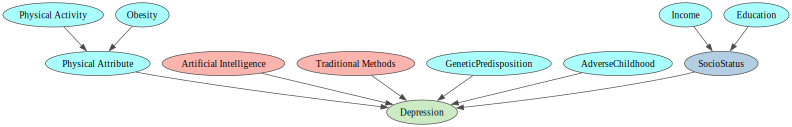

In [31]:

# Create a dictionary that maps every node (by its ID) to 1 except for Chatbot.
node_colors = {bn.variable(i).name(): 1 for i in range(bn.size())}

# If you need to add Chatbot with a different value (say 0.1), add it separately:
node_colors["Artificial Intelligence"] = 0.1
node_colors["Traditional Methods"] = 0.1
node_colors["SocioStatus"] = 0.2
node_colors["Depression"] = 0.3

# Show the Bayesian network with graphical scaling and a colored Chatbot node.
graph = gnb.show(bn, size="11", nodeColor=node_colors)


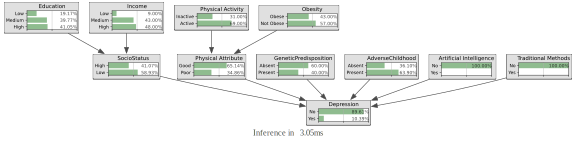

In [32]:
gnb.showInference(bn, evs={})

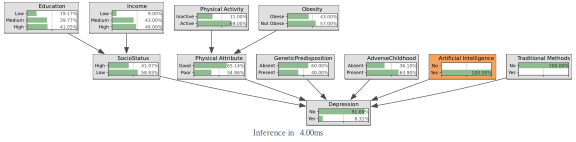

In [33]:
gnb.showInference(bn, evs={"Artificial Intelligence": "Yes"})

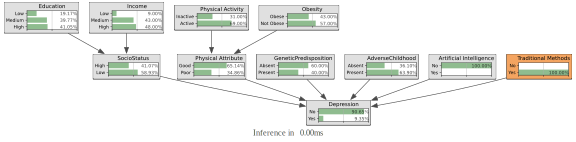

In [34]:
gnb.showInference(bn, evs={"Traditional Methods": "Yes"})


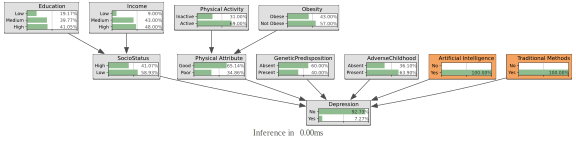

In [35]:
gnb.showInference(bn, evs={"Artificial Intelligence": "Yes", "Traditional Methods": "Yes"})

In [36]:
# Iterate over all nodes in the BN and show their CPTs:
for node in bn.nodes():
    var_name = bn.variable(node).name()
    print(f"Statistics for {var_name}:")
    gnb.showPotential(bn.cpt(node))

Statistics for Education:


Statistics for Income:


Statistics for SocioStatus:


Statistics for Physical Activity:


Statistics for Obesity:


Statistics for Physical Attribute:


Statistics for GeneticPredisposition:


Statistics for AdverseChildhood:


Statistics for Artificial Intelligence:


Statistics for Traditional Methods:


Statistics for Depression:
